In [ ]:
import numpy as np
import juliet
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams["figure.figsize"] = (25,10)

In this Notebook we will be doing the Discovery of the Transits with a well known and tested all Purpose Package for Expoplanet Discoveries.  [Juliet](https://github.com/nespinoza/juliet) Espinoza 2018

We first start by importing the Data with from our FITS file.

In [ ]:
t, f, ferr = juliet.get_TESS_data("Data/hlsp_tess-data-alerts_tess_phot_00261136679-s01_tess_v1_lc.fits")
# Juliet fits with the Help of Dictionaries thus we have to introduce these for our data
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t,f,ferr

No handles with labels found to put in legend.


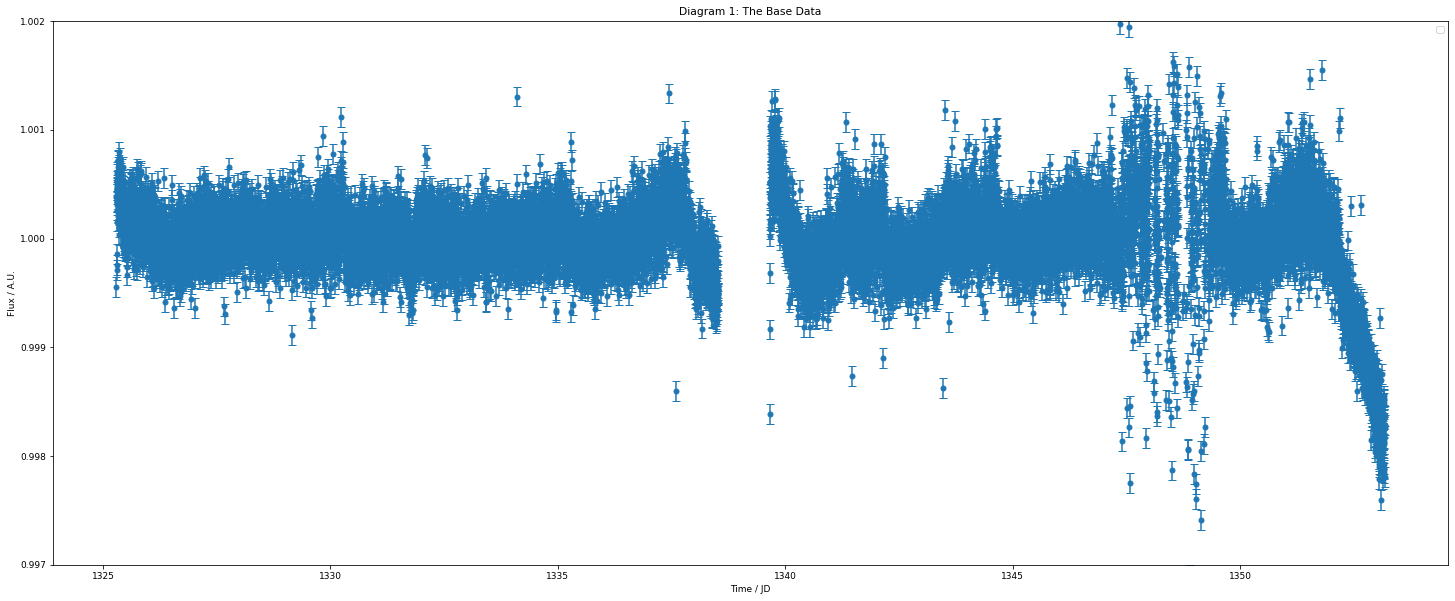

In [ ]:
plt.title("Diagram 1: The Base Data")
plt.errorbar(t, f, yerr=ferr, fmt='o',capsize=4)
plt.ylim(0.997,1.002)
plt.ylabel("Flux / A.U.")
plt.xlabel("Time / JD")
plt.legend()

As we did previously we need to detrend the data we do this by applying a gaussian Process that is inbuilt into the Juliet package. We use the GP_regressor_lc Parameter and pass it our time array. To not Detrend our actual Signals we will use the Period we have estimated in [Periods.ipynb](Periods.ipynb) to mask the rough area of our transits. We also need to use the time of our transit where we use the once we found in [Transit Multi Filter](Transits_Multi_Filter.ipynb)

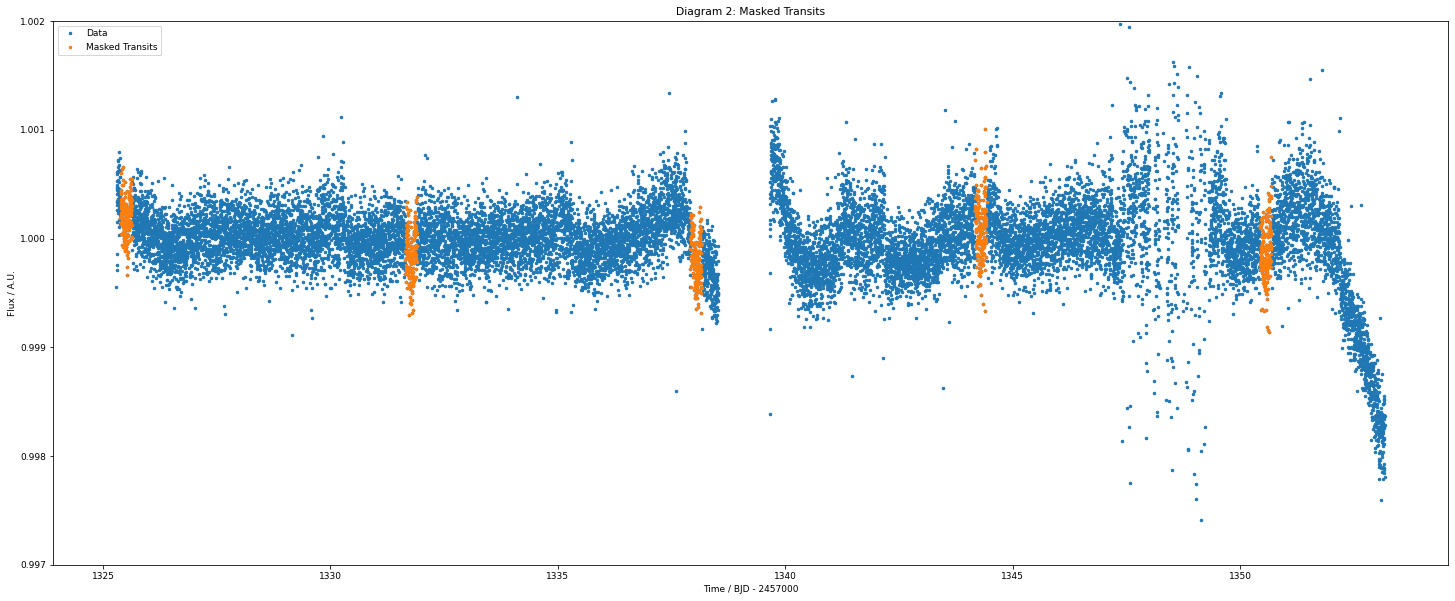

In [ ]:
# Period and t0 from Anderson et al. (201X):
P,t0 =  6.263 ,  1331.77198328
# Get phases --- identify out-of-transit (oot) times by phasing the data
# and selecting all points at absolute phases larger than 0.02:
phases = juliet.utils.get_phases(t, P, t0)
mask = np.abs(phases)>0.02
idx_oot = np.where(mask)[0]
# Save the out-of-transit data into dictionaries so we can feed them to juliet:
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t[idx_oot],f[idx_oot],ferr[idx_oot]


plt.title("Diagram 2: Masked Transits")
plt.plot(t,f,".",label="Data")
plt.plot(t[~mask],f[~mask],".",label="Masked Transits")
plt.ylim(0.997,1.002)
plt.ylabel("Flux / A.U.")
plt.xlabel("Time / BJD - 2457000")
plt.legend()

In [ ]:
params =  ['mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS', 'GP_sigma_TESS', \
           'GP_rho_TESS']
dists =   ['fixed',          'normal',     'loguniform',   'loguniform',\
           'loguniform']
hyperps = [1., [0.,0.1], [1e-6, 1e6], [1e-6, 1e6],\
           [1e-3,1e3]]

priors = {}
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

# Perform the juliet fit. Load dataset first (note the GP regressor will be the times):
dataset_gp = juliet.load(priors=priors, t_lc = times, y_lc = fluxes, yerr_lc = fluxes_error, GP_regressors_lc = times, out_folder = 'Pi_men_detrending')
# Fit:
results_gp = dataset_gp.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from Pi_men_detrending/_dynesty_NS_posteriors.pkl


Text(0.5, 0, 'Time (BJD - 2457000)')

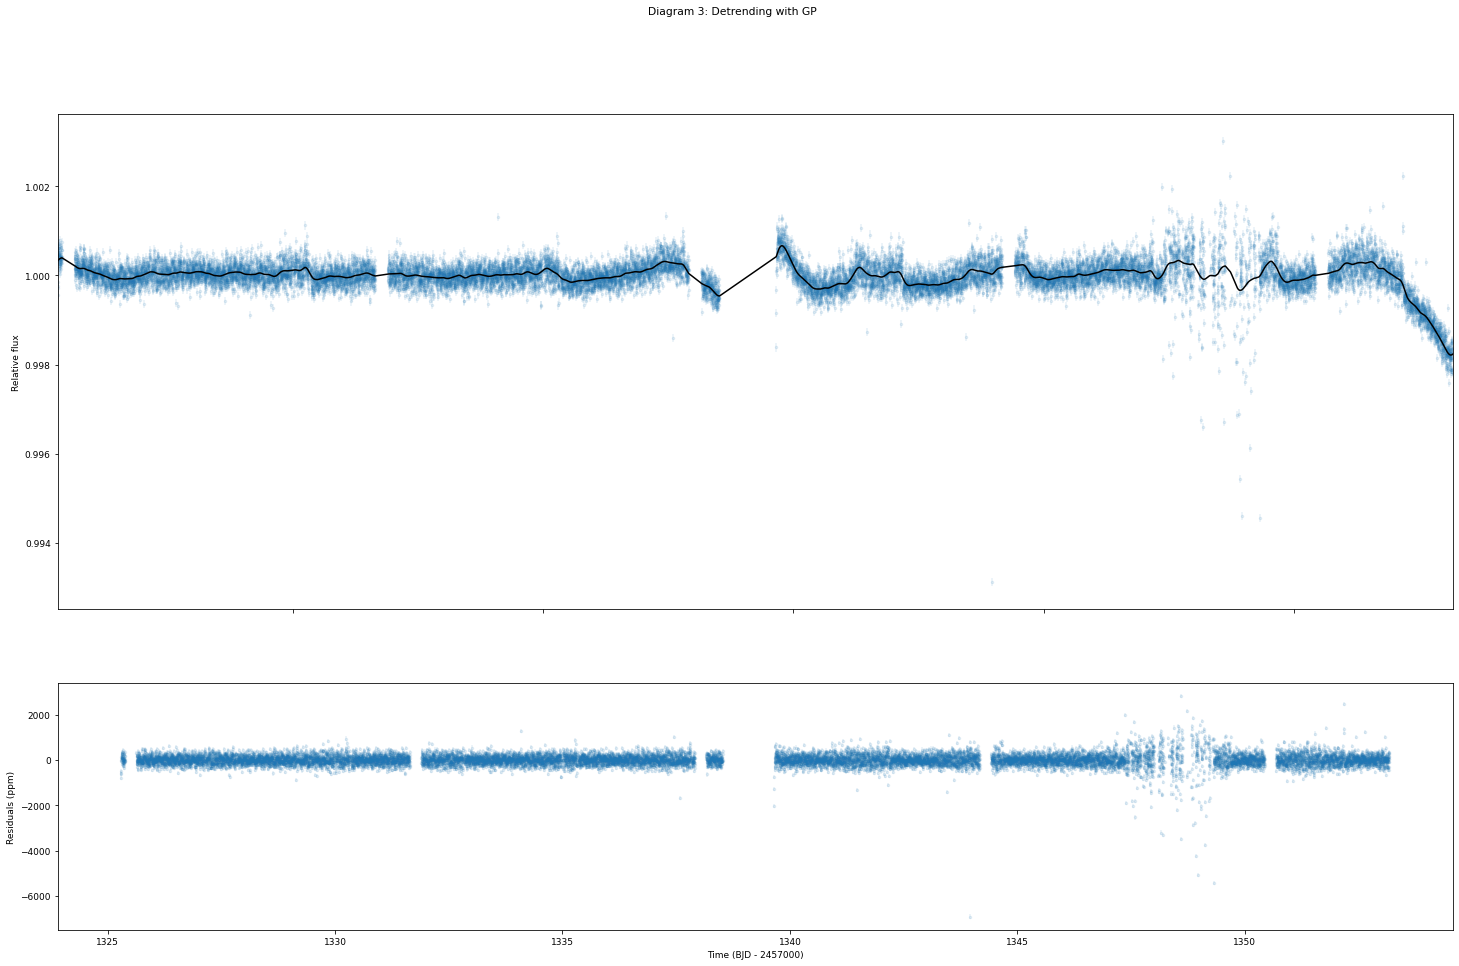

In [ ]:
# Get juliet model prediction for the full lightcurve:
model_fit = results_gp.lc.evaluate('TESS')

# Plot:
fig = plt.figure(figsize=(25,15))
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])

# First the data and the model on top:
fig.suptitle("Diagram 3: Detrending with GP")
ax1 = plt.subplot(gs[0])
ax1.errorbar(times['TESS'], fluxes['TESS'], fluxes_error['TESS'],fmt='.',alpha=0.1)
ax1.plot(times['TESS'], model_fit, color='black', zorder=100)
ax1.set_ylabel('Relative flux')
ax1.set_xlim(np.min(times['TESS']),np.max(times['TESS']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Now the residuals:
ax2 = plt.subplot(gs[1])
ax2.errorbar(times['TESS'], (fluxes['TESS']-model_fit)*1e6, \
             fluxes_error['TESS']*1e6,fmt='.',alpha=0.1)
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD - 2457000)')

Now that we have fitted the Gaussian Process to our Data such that we can eliminate Systematic Errors We need to prepare the Data for further Fitting of the Transits. We also need to create some empty priors for the corresponding Parameters that we want to fit.

In [ ]:
# Get model prediction from juliet:
model_prediction = results_gp.lc.evaluate('TESS', t = t, GPregressors = t)

# Repopulate dictionaries with new detrended flux:
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t, f/model_prediction,  ferr/model_prediction


priors = {} 

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS','q2_TESS','ecc_p1','omega_p1',\
              'rho', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS']

# Distributions:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform']

# Hyperparameters you can see these as guesses for the Fit Parameters, they depend on the type of distribution chosen for the Parameter "normal" depends on mu and std [mu,std] and uniform is between lower and upper bounds [a,b]
hyperps = [[6.26,0.1], [1331.7,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [100., 10000.], 1.0, [0.,0.1], [0.1, 1000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

We now try to fit four our Parameters

In [ ]:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes, \
                   yerr_lc = fluxes_error, out_folder = 'Pi Men')

results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.
18682it [26:51, 11.59it/s, +500 | bound: 271 | nc: 1 | ncall: 449821 | eff(%):  4.264 | loglstar:   -inf < 123350.329 <    inf | logz: 123313.535 +/-  0.380 | dlogz:  0.001 >  0.509]


We now extract the Results

In [ ]:
transit_model, transit_up68, transit_low68  = results.lc.evaluate('TESS', return_err=True)

# To plot the phased lighcurve we need the median period and time-of-transit center:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']),\
        np.median(results.posteriors['posterior_samples']['t0_p1'])
#get the Phases
phases = juliet.get_phases(dataset.times_lc['TESS'], P, t0)

(0.997, 1.002)

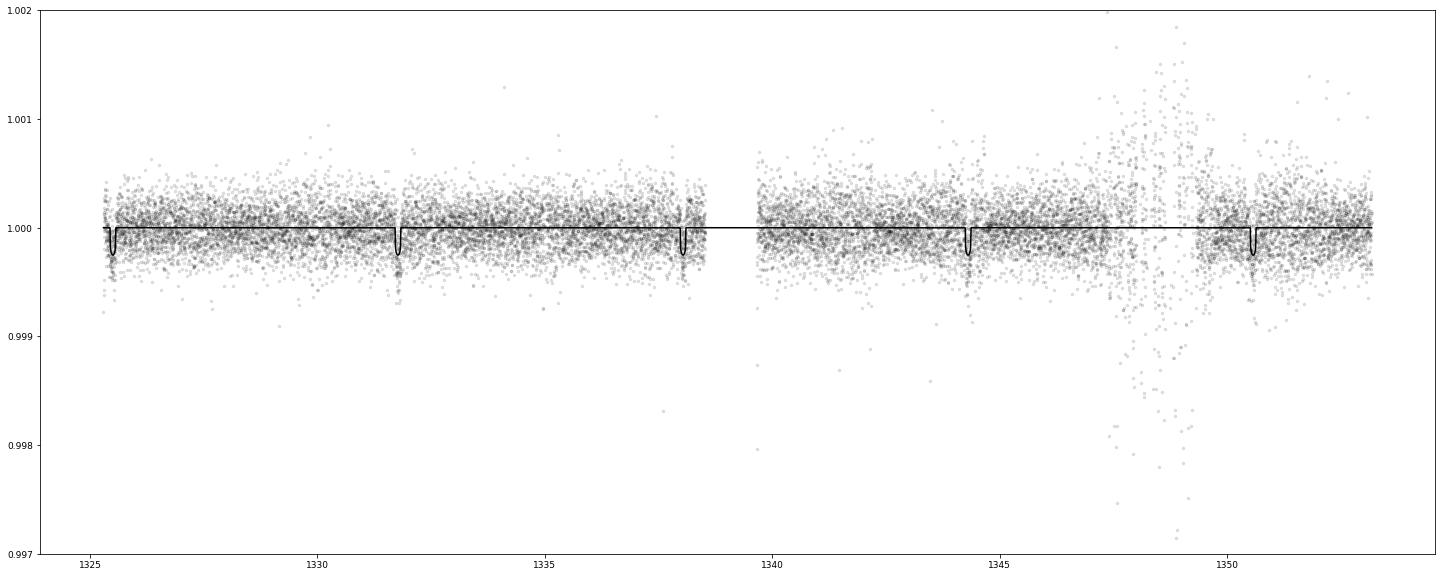

In [ ]:
plt.title("Diagram 4: All Transits")
plt.plot(dataset.times_lc['TESS'], dataset.data_lc['TESS'], 'k.' , alpha = 0.1)
plt.plot(dataset.times_lc['TESS'], transit_model, color='black',zorder=10)
plt.ylabel("Flux / A.U.")
plt.xlabel("Time / BJD - 2457000")
plt.ylim(0.997,1.002)

(0.997, 1.002)

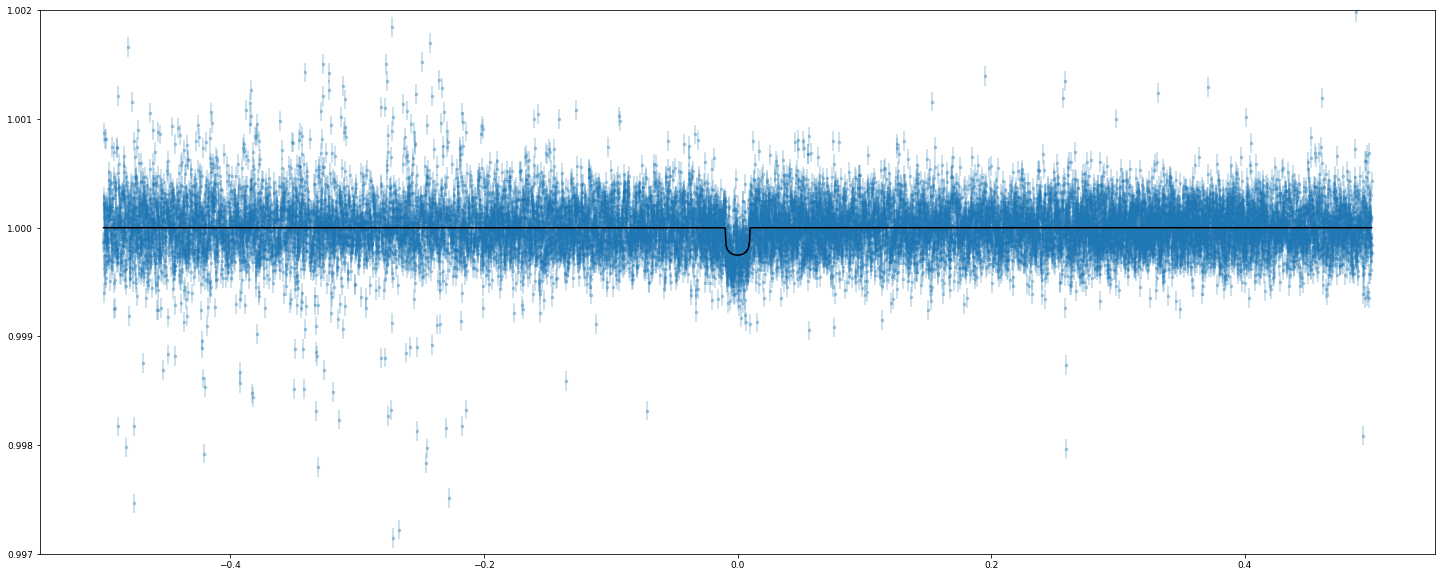

In [ ]:
idx = np.argsort(phases)
plt.title("Diagram 5: Phase of the Transit")
plt.plot(phases[idx],transit_model[idx], color='black',zorder=10)
plt.errorbar(phases, dataset.data_lc['TESS'], yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.3)
plt.xlim()
plt.ylabel("Flux / A.U.")
plt.xlabel("Phase / d")
plt.ylim(0.997,1.002)

Now we have our fit and as we can observe it seems to be fitting our data very well. Now we want to extract our Fit Parameters from our Posterior distribution. We need to pay attention that some of our Fit Parameters are a bit specially Parameterized for example the impact parameter b and the ratio $p =\frac{r_p}{r_s}$ is hidden in the parameters r1 and r2. We will write a small function to give us all our parameters of interest. We can also calculate the a/Rs ratio with the help of $\rho$ see https://iopscience.iop.org/article/10.3847/1538-3881/aa94bf/pdf

In [ ]:
from astropy import units as u
from astropy.units import cds
def getParams(posteriors):
    post_samp = posteriors["posterior_samples"]
    Params = {}
    quant = juliet.utils.get_quantiles

    r1,r2 = post_samp["r1_p1"],post_samp["r2_p1"]
    b,p = juliet.utils.reverse_bp(r1, r2, 0., 1.)
    Params["b"],Params["p"] = quant(b),quant(p)
    Params["P"] = quant(post_samp["P_p1"])
    Params["t0"] = quant(post_samp["t0_p1"])
    a = (post_samp["rho"]*u.kg/u.m**3*cds.G*post_samp["P_p1"]**2*u.d**2/(3*np.pi)).si.value
    a = a**(1/3)
    Params["a/R"] = quant(a)

    print("x | median | upper 68% | lower 68%")
    for par in Params:
        print(f"{par} | {Params[par][0]:.3e} | {Params[par][1]:.3e} | {Params[par][2]:.3e}")

    return Params

Planet_Params = getParams(results.posteriors)

x | median | upper 68% | lower 68%
b | 5.930e-01 | 8.119e-01 | 2.486e-01
p | 1.527e-02 | 1.637e-02 | 1.442e-02
P | 6.267e+00 | 6.268e+00 | 6.265e+00
t0 | 1.332e+03 | 1.332e+03 | 1.332e+03
a/R | 1.324e+01 | 1.586e+01 | 9.731e+00


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b43e0c11-0b97-4e39-8716-b644d99b659d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>